In [2]:
import os
import json

json_folder = 'GL_v2\Labeled_GL_sample_2'
json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]

data_list = []
for file_name in json_files:
    file_path = os.path.join(json_folder, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data_list.append(data)

<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Sacchi\AppData\Local\Temp\ipykernel_19636\2739048521.py:4: SyntaxWarning: invalid escape sequence '\L'
  json_folder = 'GL_v2\Labeled_GL_sample_2'


chuyển thành bản đẹp


In [3]:
# Beautify all JSON files in the folder
for file_name in json_files:
    file_path = os.path.join(json_folder, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4, sort_keys=True)
print("All JSON files have been beautified.")

All JSON files have been beautified.


Thống kê các annotation và fleiss kappa

In [4]:
# Lập bảng tổng hợp annotator x choice và tính Fleiss' kappa cho từng trường from_name, xuất ra 1 bảng tổng hợp kết quả kappa

import os
import json
import pandas as pd
import numpy as np

def fleiss_kappa(M):
    """
    M: numpy array (n_items, n_categories), mỗi dòng là số annotator chọn mỗi choice cho 1 item
    """
    N, k = M.shape
    n_annotators = np.sum(M[0])
    P = np.sum(M, axis=0) / (N * n_annotators)
    P_i = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    P_bar = np.mean(P_i)
    P_e = np.sum(P * P)
    kappa = (P_bar - P_e) / (1 - P_e) if (1 - P_e) != 0 else np.nan
    return kappa

annotators = ['Cuong', 'Duyet', 'Vuong']
choices_map = {
    'All_helpfulness': ['1', '2', '3'],
    # Các trường khác giữ nguyên 1-5
}
default_choices = ['1', '2', '3', '4', '5']

# Lấy tất cả from_name có trong các file annotator
from_names = set()
for annotator in annotators:
    path = os.path.join(json_folder, f'{annotator}.json')
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        anns = item.get('annotations', [])
        if not anns: continue
        ann = anns[0]
        for r in ann.get('result', []):
            fname = r.get('from_name')
            if fname:
                from_names.add(fname)
from_names = sorted(from_names)

kappa_results = {}
for fname in from_names:
    # Lựa chọn choices phù hợp cho từng trường
    choices = choices_map.get(fname, default_choices)
    # Tạo bảng tổng hợp annotator x choice
    rows = []
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        counts = {c: 0 for c in choices}
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        counts[val[0]] += 1
        row = [counts[c] for c in choices]
        rows.append(row)
    df = pd.DataFrame(rows, columns=[f' {c}' for c in choices], index=annotators)
    df.index.name = 'Annotator'
    print(f'Bảng tổng hợp cho trường: {fname}')
    display(df)

    # Tạo ma trận Fleiss: mỗi dòng là 1 item, mỗi cột là số annotator chọn choice đó
    rows2 = []
    n_items = None
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        item_choices = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            found = False
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        item_choices.append(val[0])
                        found = True
                        break
            if not found:
                item_choices.append(None)
        rows2.append(item_choices)
        if n_items is None:
            n_items = len(item_choices)
    M = np.zeros((n_items, len(choices)), dtype=int)
    for i in range(n_items):
        for j, annotator in enumerate(annotators):
            v = rows2[j][i]
            if v is not None:
                idx = choices.index(v)
                M[i, idx] += 1
    kappa = fleiss_kappa(M)
    kappa_results[fname] = kappa
    print(f"Fleiss' kappa cho trường {fname}: {kappa:.4f}")

# Xuất bảng tổng hợp Fleiss' kappa
kappa_df = pd.DataFrame.from_dict(kappa_results, orient='index', columns=['Fleiss\' kappa'])
display(kappa_df)

Bảng tổng hợp cho trường: All_helpfulness


,1,2,3
Annotator,,,
Cuong,29,17,24
Duyet,15,35,18
Vuong,12,35,23


Fleiss' kappa cho trường All_helpfulness: 0.5105
Bảng tổng hợp cho trường: Comment_helpfulness


,1,2,3,4,5
Annotator,,,,,
Cuong,1,12,26,15,16
Duyet,1,23,15,24,7
Vuong,1,7,22,33,7


Fleiss' kappa cho trường Comment_helpfulness: 0.3493
Bảng tổng hợp cho trường: Image_helpfulness


,1,2,3,4,5
Annotator,,,,,
Cuong,43,0,18,4,5
Duyet,37,7,14,3,9
Vuong,36,6,12,5,11


Fleiss' kappa cho trường Image_helpfulness: 0.7051


,Fleiss' kappa
All_helpfulness,0.510456
Comment_helpfulness,0.349321
Image_helpfulness,0.705077


# EDA: Phân tích nguyên nhân độ đồng thuận thấp giữa các annotator

Phân tích phân phối lựa chọn của từng annotator, kiểm tra sự khác biệt giữa các annotator, và tìm các trường hợp bất đồng mạnh.

--- Phân tích trường: All_helpfulness ---


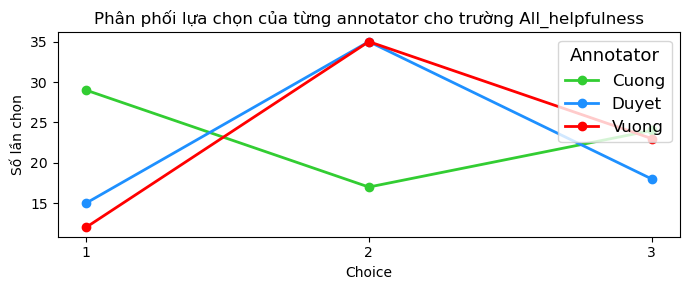

Số item bất đồng hoàn toàn (0/70): []
Tỉ lệ trùng giữa Cuong và Duyet: 47/68 = 69.12%
Tỉ lệ trùng giữa Cuong và Vuong: 46/70 = 65.71%
Tỉ lệ trùng giữa Duyet và Vuong: 50/68 = 73.53%

--- Phân tích trường: Comment_helpfulness ---


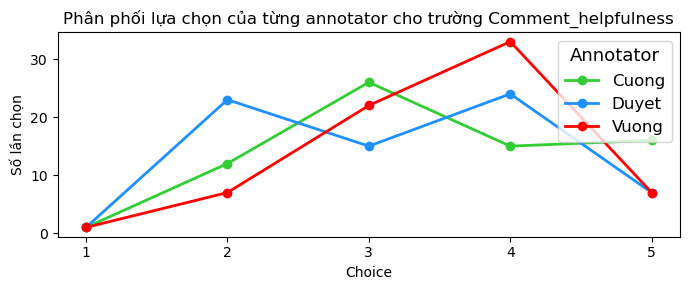

Số item bất đồng hoàn toàn (6/70): [13, 23, 48, 61, 62, 63]
Tỉ lệ trùng giữa Cuong và Duyet: 36/70 = 51.43%
Tỉ lệ trùng giữa Cuong và Vuong: 41/70 = 58.57%
Tỉ lệ trùng giữa Duyet và Vuong: 33/70 = 47.14%

--- Phân tích trường: Image_helpfulness ---


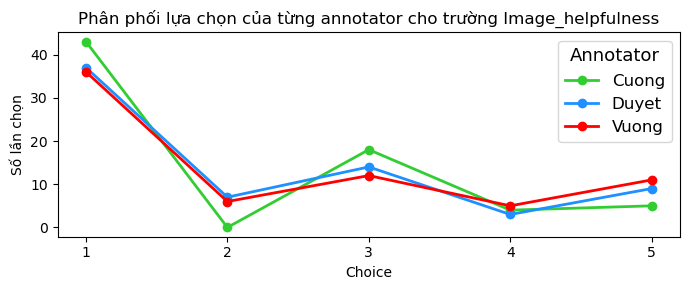

Số item bất đồng hoàn toàn (3/70): [22, 61, 64]
Tỉ lệ trùng giữa Cuong và Duyet: 56/70 = 80.00%
Tỉ lệ trùng giữa Cuong và Vuong: 52/70 = 74.29%
Tỉ lệ trùng giữa Duyet và Vuong: 63/70 = 90.00%



In [7]:
# EDA: Phân tích chi tiết về sự khác biệt giữa các annotator cho từng trường from_name

import matplotlib.pyplot as plt
import seaborn as sns

for fname in from_names:
    print(f"--- Phân tích trường: {fname} ---")
    # 1. Phân phối lựa chọn của từng annotator
    # Lựa chọn choices phù hợp cho từng trường
    choices = choices_map.get(fname, default_choices)
    fig, ax = plt.subplots(figsize=(7, 3))
    dist = []
    color_map = {'Cuong': 'limegreen', 'Duyet': 'dodgerblue', 'Vuong': 'red'}
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        choices_list = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        choices_list.append(val[0])
        counts = pd.Series(choices_list).value_counts().reindex(choices, fill_value=0)
        dist.append(counts)
        ax.plot(counts.index, counts.values, marker='o', label=annotator, color=color_map.get(annotator, None), linewidth=2)
    plt.title(f'Phân phối lựa chọn của từng annotator cho trường {fname}')
    plt.xlabel('Choice')
    plt.ylabel('Số lần chọn')
    plt.legend(annotators, fontsize=12, title="Annotator", title_fontsize=13, loc='upper right')
    plt.tight_layout()
    plt.show()

    # 2. Phân tích các item có bất đồng mạnh (tức là các annotator chọn khác nhau hoàn toàn)
    # Tạo ma trận annotator x item (giá trị choice)
    rows2 = []
    n_items = None
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        item_choices = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            found = False
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        item_choices.append(val[0])
                        found = True
                        break
            if not found:
                item_choices.append(None)
        rows2.append(item_choices)
        if n_items is None:
            n_items = len(item_choices)
    # Tìm các item mà tất cả annotator đều chọn khác nhau (không trùng)
    disagreement_items = []
    for i in range(n_items):
        vals = [rows2[j][i] for j in range(len(annotators)) if rows2[j][i] is not None]
        if len(set(vals)) == len(vals) and len(vals) == len(annotators):
            disagreement_items.append(i)
    print(f"Số item bất đồng hoàn toàn ({len(disagreement_items)}/{n_items}): {disagreement_items[:10]}{'...' if len(disagreement_items)>10 else ''}")

    # 3. Phân tích các cặp annotator: tỉ lệ trùng lặp lựa chọn
    for i in range(len(annotators)):
        for j in range(i+1, len(annotators)):
            agree = 0
            total = 0
            for k in range(n_items):
                v1 = rows2[i][k]
                v2 = rows2[j][k]
                if v1 is not None and v2 is not None:
                    total += 1
                    if v1 == v2:
                        agree += 1
            print(f"Tỉ lệ trùng giữa {annotators[i]} và {annotators[j]}: {agree}/{total} = {agree/total:.2%}" if total else f"{annotators[i]} vs {annotators[j]}: không đủ dữ liệu")
    print()

In [ ]:
# Tìm outlier và thống kê insight cho từng trường from_name
import numpy as np

for fname in from_names:
    print(f"--- Outlier & Insight cho trường: {fname} ---")
    choices = choices_map.get(fname, default_choices)
    all_choices = []
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        all_choices.append(int(val[0]))
    if not all_choices:
        print("Không có dữ liệu.")
        continue
    arr = np.array(all_choices)
    # Thống kê cơ bản
    print(f"Số lượng: {len(arr)}")
    print(f"Mean: {np.mean(arr):.2f}, Median: {np.median(arr)}, Std: {np.std(arr):.2f}, Min: {np.min(arr)}, Max: {np.max(arr)}")
    # Tìm outlier theo IQR
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = arr[(arr < lower) | (arr > upper)]
    print(f"Số lượng outlier (theo IQR): {len(outliers)}")
    if len(outliers) > 0:
        print(f"Giá trị outlier: {np.unique(outliers)}")
    print()